### Models

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 4개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv
📊 데이터 Shape: I=4, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=757.00, M2=1855.00


In [9]:
only = gp.Model("only")
only.setParam('OutputFlag', 0)
only.setParam("MIPGap", 1e-7)

x_ind = only.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x_individual")
yp_ind = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus_individual")
ym_ind = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus_individual")

M = max(R[i, t, s] for i in range(I) for t in range(T) for s in range(S))
z = only.addVars(I, T, S, vtype=GRB.BINARY, name="z")

only.update()

obj = gp.quicksum(P_DA[t] * x_ind[i, t] for i in range(I) for t in range(T)) + gp.quicksum(1 / S * (P_RT[t, s] * yp_ind[i, t, s] - P_PN[t] * ym_ind[i, t, s]) for i in range(I) for t in range(T) for s in range(S))
only.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    only.addConstr(R[i, t, s] - x_ind[i, t] == yp_ind[i, t, s] - ym_ind[i, t, s])
    only.addConstr(yp_ind[i, t, s] <= R[i, t, s])
    only.addConstr(yp_ind[i, t, s] <= M * z[i, t, s])
    only.addConstr(ym_ind[i, t, s] <= M * (1 - z[i, t, s]))

only.optimize()

if only.status == GRB.OPTIMAL:
    print(f"Objective value: {only.objVal}")
else:
    print("No optimal solution found.")
    
x_ind_vals = np.array([[x_ind[i, t].x for t in range(T)] for i in range(I)])
y_plus_ind_vals = np.array([[[yp_ind[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)])
y_minus_ind_vals = np.array([[[ym_ind[i, t, s].x for s in range(S)] for t in range(T)] for i in range(I)])

Objective value: 1400541.200788068


In [10]:
agg = gp.Model("agg")
agg.setParam('OutputFlag', 0)
agg.setParam("MIPGap", 1e-7)

a_agg = agg.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="alpha")
bp_agg = agg.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="beta_plus")
bm_agg = agg.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="beta_minus")
M = max(sum(R[i, t, s] for i in range(I)) for t in range(T) for s in range(S))
z = agg.addVars(T, S, vtype=GRB.BINARY, name="z")
prob = np.array([1 / S for s in range(S)])

agg.update()

obj = gp.quicksum(P_DA[t] * a_agg[t] for t in range(T)) + gp.quicksum(prob[s] * (P_RT[t, s] * bp_agg[t, s] - P_PN[t] * bm_agg[t, s]) for t in range(T) for s in range(S))
agg.setObjective(obj, GRB.MAXIMIZE)

for t, s in product(range(T), range(S)):
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a_agg[t] == bp_agg[t, s] - bm_agg[t, s])
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) >= bp_agg[t, s])
    agg.addConstr(bp_agg[t, s] <= M * z[t, s])
    agg.addConstr(bm_agg[t, s] <= M * (1 - z[t, s]))

agg.optimize()

if agg.status == GRB.OPTIMAL:
    print(f"Objective value: {agg.objVal}")
else:
    print("No optimal solution found.")
    
a_agg_vals = np.array([a_agg[t].x for t in range(T)])
b_plus_ind_vals = np.array([[bp_agg[t, s].x for s in range(S)] for t in range(T)])
b_minus_ind_vals = np.array([[bm_agg[t, s].x for s in range(S)] for t in range(T)])

Objective value: 1422532.2892043192


In [11]:
set = gp.Model("Settlement") 
set.setParam('OutputFlag', 0)
set.setParam("PoolSolutions", 15)
set.setParam("PoolSearchMode", 2)
set.setParam("PoolGap", 0.05)

a = set.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="alpha")
bp = set.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="beta_plus")
bm = set.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="beta_minus")
x = set.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
zy = set.addVars(I, T, S, vtype=GRB.BINARY, name="z_y")

d = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_minus")
ze = set.addVars(T, S, vtype=GRB.BINARY, name="z_e") 
set.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + gp.quicksum(1/S * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s]) for t in range(T) for s in range(S))

set.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s])
    set.addConstr(yp[i, t, s] <= R[i, t, s])
    set.addConstr(ep[i,t,s] == yp[i,t,s] - gp.quicksum(d[i,j,t,s] for j in range(I) if j != i))
    set.addConstr(em[i,t,s] == ym[i,t,s] - gp.quicksum(d[j,i,t,s] for j in range(I) if j != i))
    set.addConstr(gp.quicksum(d[i, j, t, s] for j in range(I) if j != i) <= yp[i, t, s])
    set.addConstr(gp.quicksum(d[j, i, t, s] for j in range(I) if j != i) <= ym[i, t, s])
    set.addConstr(d[i, i, t, s] == 0)
    set.addConstr(yp[i, t, s] <= M1 * zy[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - zy[i, t, s]))
    
for t, s in product(range(T), range(S)):
    set.addConstr(a[t] == gp.quicksum(x[i, t] for i in range(I)))
    set.addConstr(bp[t,s] == gp.quicksum(ep[i, t, s] for i in range(I)))
    set.addConstr(bm[t,s] == gp.quicksum(em[i, t, s] for i in range(I)))
    set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - gp.quicksum(x[i, t] for i in range(I)) == gp.quicksum(ep[i, t, s] for i in range(I)) - gp.quicksum(em[i, t, s] for i in range(I)))
    set.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= gp.quicksum(R[i, t, s] for i in range(I)))
    set.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= M2 * ze[t, s])
    set.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) <= M2 * (1 - ze[t, s]))

set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Objective value: {set.objVal}")
else:
    print("No optimal solution found.")

Objective value: 1422532.2892043192


### Curve Derivation

In [12]:
i_target = 0
t_target = 19
x_max = 300
profits = []
aggregated_profits = []
individual_profits = []
other_individual_profits = [[] for _ in range(I)]  # 모든 참가자에 대해 리스트 만들기

for x_fixed in range(x_max + 1):
    m1 = gp.Model("x_vs_profit")
    m1.setParam("OutputFlag", 0)
    m1.setParam("MIPGap", 1e-7)

    x_ind = m1.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x_ind")
    yp_ind = m1.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus_ind")
    ym_ind = m1.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus_ind")
    z = m1.addVars(I, T, S, vtype=GRB.BINARY, name="z")

    m1.update()

    M = max(R[i, t, s] for i in range(I) for t in range(T) for s in range(S))
    obj = gp.quicksum(P_DA[t_target] * x_ind[i, t_target] for i in range(I)) + gp.quicksum(
        1 / S * (P_RT[t_target, s] * yp_ind[i, t_target, s] - P_PN[t_target] * ym_ind[i, t_target, s])
        for i in range(I) for s in range(S)
    )
    m1.setObjective(obj, GRB.MAXIMIZE)

    for i, s in product(range(I), range(S)):
        t = t_target
        m1.addConstr(R[i, t, s] - x_ind[i, t] == yp_ind[i, t, s] - ym_ind[i, t, s])
        m1.addConstr(yp_ind[i, t, s] <= R[i, t, s])
        m1.addConstr(yp_ind[i, t, s] <= M * z[i, t, s])
        m1.addConstr(ym_ind[i, t, s] <= M * (1 - z[i, t, s]))

    # x 고정
    m1.addConstr(x_ind[i_target, t_target] == x_fixed)

    m1.optimize()

    if m1.status == GRB.OPTIMAL:
        prof = P_DA[t_target] * x_ind[i_target, t_target].X + sum(
        1 / S * (P_RT[t_target, s] * yp_ind[i_target, t_target, s].X - P_PN[t_target] * ym_ind[i_target, t_target, s].X)
        for s in range(S)
        )
        profits.append(prof)
    else:
        profits.append(None)

for x_fixed in range(x_max + 1):
    m2 = gp.Model("Settlement_x_fixed")
    m2.setParam("OutputFlag", 0)
    a = m2.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="alpha")
    bp = m2.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="beta_plus")
    bm = m2.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="beta_minus")
    x = m2.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    yp = m2.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
    ym = m2.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
    zy = m2.addVars(I, T, S, vtype=GRB.BINARY, name="z_y")
    d = m2.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
    ep = m2.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_plus")
    em = m2.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_minus")
    ze = m2.addVars(T, S, vtype=GRB.BINARY, name="z_e") 

    m2.update()

    obj = P_DA[t_target] * a[t_target] + gp.quicksum(1/S * (P_RT[t_target, s] * bp[t_target, s] - P_PN[t_target] * bm[t_target, s]) for s in range(S))
    m2.setObjective(obj, GRB.MAXIMIZE)

    for i, t, s in product(range(I), range(T), range(S)):
        t = t_target
        m2.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s])
        m2.addConstr(yp[i, t, s] <= R[i, t, s])
        m2.addConstr(yp[i, t, s] <= M1 * zy[i, t, s])
        m2.addConstr(ym[i, t, s] <= M1 * (1 - zy[i, t, s]))
        m2.addConstr(ep[i,t,s] == yp[i,t,s] - gp.quicksum(d[i,j,t,s] for j in range(I) if j != i))
        m2.addConstr(em[i,t,s] == ym[i,t,s] - gp.quicksum(d[j,i,t,s] for j in range(I) if j != i))
        m2.addConstr(gp.quicksum(d[i, j, t, s] for j in range(I) if j != i) <= yp[i, t, s])
        m2.addConstr(gp.quicksum(d[j, i, t, s] for j in range(I) if j != i) <= ym[i, t, s])
        m2.addConstr(d[i, i, t, s] == 0)

    for t, s in product(range(T), range(S)):
        t = t_target
        m2.addConstr(a[t] == gp.quicksum(x[i, t] for i in range(I)))
        m2.addConstr(bp[t,s] == gp.quicksum(ep[i, t, s] for i in range(I)))
        m2.addConstr(bm[t,s] == gp.quicksum(em[i, t, s] for i in range(I)))
        m2.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - gp.quicksum(x[i, t] for i in range(I)) ==
                    gp.quicksum(ep[i, t, s] for i in range(I)) - gp.quicksum(em[i, t, s] for i in range(I)))
        m2.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= gp.quicksum(R[i, t, s] for i in range(I)))
        m2.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= M2 * ze[t, s])
        m2.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) <= M2 * (1 - ze[t, s]))

    # x 고정!
    m2.addConstr(x[i_target, t_target] == x_fixed)

    m2.optimize()

    if m2.status == GRB.OPTIMAL:
        aggregated_profits.append(m2.objVal)
        ind_profit = (P_DA[t_target] * x[i_target, t_target].X
                    + sum(1/S * (P_RT[t_target, s] * ep[i_target, t_target, s].X - P_PN[t_target] * em[i_target, t_target, s].X)
                    for s in range(S)))
        individual_profits.append(ind_profit)
        for i in range(I):
            if i == i_target:
                other_individual_profits[i].append(None)  # i_target 참가자는 제외 표시
            else:
                profit_i = (P_DA[t_target] * x[i, t_target].X
                            + sum(1/S * (P_RT[t_target, s] * ep[i, t_target, s].X - P_PN[t_target] * em[i, t_target, s].X)
                                for s in range(S)))
                other_individual_profits[i].append(profit_i)
    else:
        aggregated_profits.append(None)
        individual_profits.append(None)
        for i in range(I):
            other_individual_profits[i].append(None)

# (1) x를 고정하지 않은 자유모델 한번 풀기
m2_free = gp.Model("Settlement_free")
m2_free.setParam("OutputFlag", 0)

a = m2_free.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="alpha")
bp = m2_free.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="beta_plus")
bm = m2_free.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="beta_minus")
x = m2_free.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = m2_free.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = m2_free.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
zy = m2_free.addVars(I, T, S, vtype=GRB.BINARY, name="z_y")
d = m2_free.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
ep = m2_free.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_plus")
em = m2_free.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="e_minus")
ze = m2_free.addVars(T, S, vtype=GRB.BINARY, name="z_e")

m2_free.update()

# objective (그대로)
obj = P_DA[t_target] * a[t_target] + gp.quicksum(
    1/S * (P_RT[t_target, s] * bp[t_target, s] - P_PN[t_target] * bm[t_target, s])
    for s in range(S)
)
m2_free.setObjective(obj, GRB.MAXIMIZE)

# constraints (t_target에 대해서만)
for i, s in product(range(I), range(S)):
    t = t_target
    m2_free.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s])
    m2_free.addConstr(yp[i, t, s] <= R[i, t, s])
    m2_free.addConstr(yp[i, t, s] <= M1 * zy[i, t, s])
    m2_free.addConstr(ym[i, t, s] <= M1 * (1 - zy[i, t, s]))
    m2_free.addConstr(ep[i,t,s] == yp[i,t,s] - gp.quicksum(d[i,j,t,s] for j in range(I) if j != i))
    m2_free.addConstr(em[i,t,s] == ym[i,t,s] - gp.quicksum(d[j,i,t,s] for j in range(I) if j != i))
    m2_free.addConstr(gp.quicksum(d[i, j, t, s] for j in range(I) if j != i) <= yp[i, t, s])
    m2_free.addConstr(gp.quicksum(d[j, i, t, s] for j in range(I) if j != i) <= ym[i, t, s])
    m2_free.addConstr(d[i, i, t, s] == 0)

for s in range(S):
    t = t_target
    m2_free.addConstr(a[t] == gp.quicksum(x[i, t] for i in range(I)))
    m2_free.addConstr(bp[t,s] == gp.quicksum(ep[i, t, s] for i in range(I)))
    m2_free.addConstr(bm[t,s] == gp.quicksum(em[i, t, s] for i in range(I)))
    m2_free.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - gp.quicksum(x[i, t] for i in range(I)) ==
                    gp.quicksum(ep[i, t, s] for i in range(I)) - gp.quicksum(em[i, t, s] for i in range(I)))
    m2_free.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= gp.quicksum(R[i, t, s] for i in range(I)))
    m2_free.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) <= M2 * ze[t, s])
    m2_free.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) <= M2 * (1 - ze[t, s]))

# (2) optimize!
m2_free.optimize()

# (3) 최적의 x 값 추출
if m2_free.status == GRB.OPTIMAL:
    optimal_x_val = x[i_target, t_target].x
else:
    optimal_x_val = None

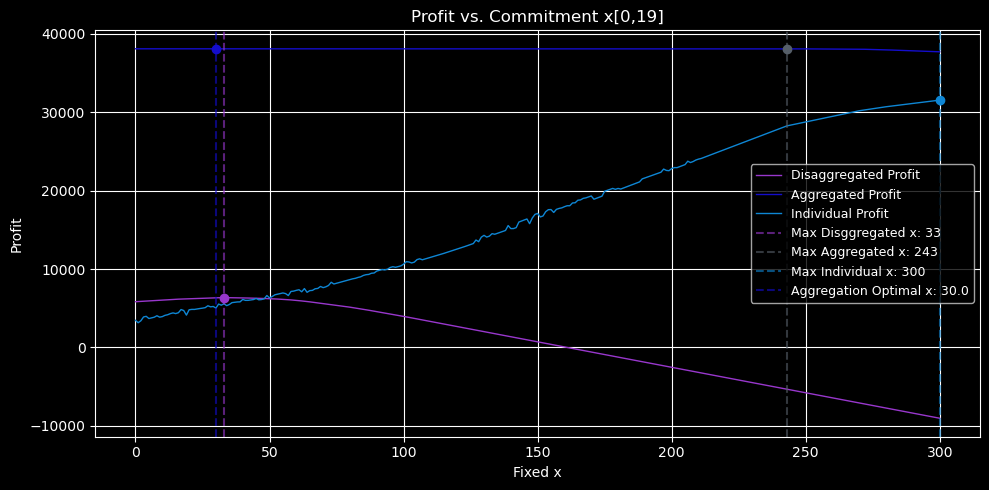

In [13]:
profits_array = np.array(profits, dtype=np.float64)
aggregated_profits_array = np.array(aggregated_profits, dtype=np.float64)
individual_profits_array = np.array(individual_profits, dtype=np.float64)

max_val=np.nanmax(profits_array)
max_idx = np.where(profits_array == max_val)[0][-1]

agg_max_val = np.nanmax(aggregated_profits_array)
agg_max_idx = np.where(aggregated_profits_array == agg_max_val)[0][-1]

ind_max_val = np.nanmax(individual_profits_array)
ind_max_idx = np.where(individual_profits_array == ind_max_val)[0][-1]

plt.figure(figsize=(10, 5))
plt.plot(range(x_max + 1), profits, ms=2, color='#9837cc', label="Disaggregated Profit", lw=1)
plt.plot(range(x_max + 1), aggregated_profits_array, color='#140DCC', label="Aggregated Profit", linewidth=1)
plt.plot(range(x_max + 1), individual_profits_array, color='#0E86D4', linestyle='-', label="Individual Profit", linewidth=1)

plt.axvline(x=max_idx, color='#9837cc', alpha=0.6, linestyle='--', label=f'Max Disggregated x: {max_idx}')
plt.plot(max_idx, max_val, marker='o', color='#9837cc')
plt.axvline(x=agg_max_idx, color='#565f69', alpha=0.6, linestyle='--', label=f'Max Aggregated x: {agg_max_idx}')
plt.plot(agg_max_idx, agg_max_val, marker='o', color='#565f69')
plt.axvline(x=ind_max_idx, color='#0E86D4', alpha=0.6, linestyle='--', label=f'Max Individual x: {ind_max_idx}')
plt.plot(ind_max_idx, ind_max_val, marker='o', color='#0E86D4')
if 'optimal_x_val' in locals() and optimal_x_val is not None:
    plt.axvline(optimal_x_val, color='#140DCC', alpha = 0.6, linestyle='--', linewidth=1.5, label=f'Aggregation Optimal x: {optimal_x_val}')
    opt_idx = int(round(optimal_x_val))
    if 0 <= opt_idx <= x_max:
        opt_val = aggregated_profits_array[opt_idx]
        plt.plot(optimal_x_val, opt_val, marker='o', color='#140DCC')


plt.title(f"Profit vs. Commitment x[{i_target},{t_target}]")
plt.xlabel("Fixed x")
plt.ylabel("Profit")
plt.grid(True)
plt.legend(prop={'size': 9})
plt.tight_layout()
plt.show()


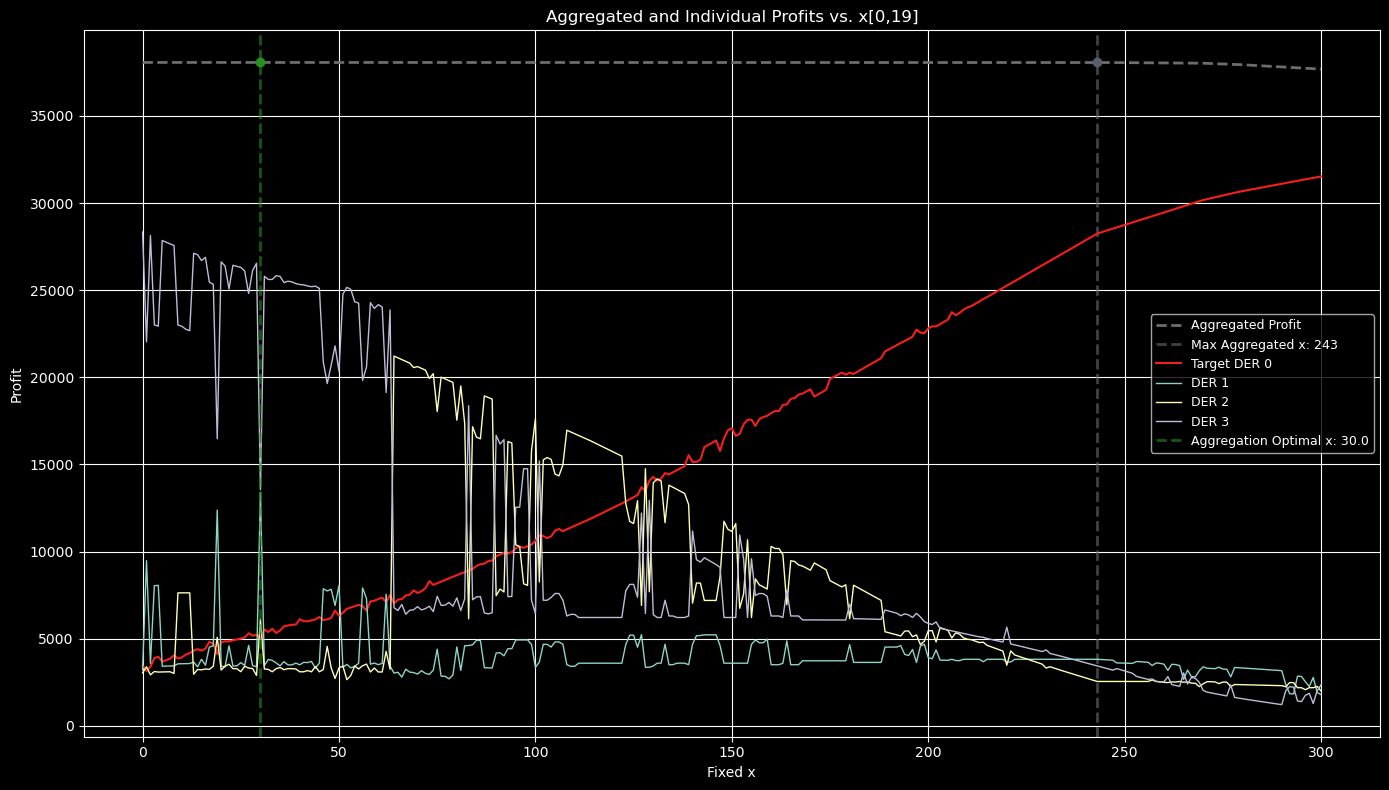

In [14]:
x_vals = list(range(x_max + 1))
aggregated_profits_array = np.array(aggregated_profits, dtype=np.float64)
agg_max_val = np.nanmax(aggregated_profits_array)
agg_max_idx = np.where(aggregated_profits_array == agg_max_val)[0][-1]

plt.figure(figsize=(14, 8))
plt.plot(x_vals, aggregated_profits, label="Aggregated Profit", color='#6d6d70', linewidth=2, ls = '--')
plt.axvline(x=agg_max_idx, color='#6d6d70', lw =2, alpha=0.6, linestyle='--', label=f'Max Aggregated x: {agg_max_idx}')
plt.plot(agg_max_idx, agg_max_val, marker='o', color='#565f69')


for i in range(I):
    if i == i_target:
        plt.plot(x_vals, individual_profits, label=f'Target DER {i_target}', linestyle='-', linewidth=1.5, color='#f51f1b')
    else:
        plt.plot(x_vals, other_individual_profits[i], label=f'DER {i}', linestyle='-', linewidth=1)
if 'optimal_x_val' in locals() and optimal_x_val is not None:
    plt.axvline(optimal_x_val, color='#26911f', alpha = 0.6, linestyle='--', linewidth=2, label=f'Aggregation Optimal x: {optimal_x_val}')
    opt_idx = int(round(optimal_x_val))
    if 0 <= opt_idx <= x_max:
        opt_val = aggregated_profits_array[opt_idx]
        plt.plot(optimal_x_val, opt_val, marker='o', color='#26911f')
        
plt.title(f"Aggregated and Individual Profits vs. x[{i_target},{t_target}]")
plt.xlabel("Fixed x")
plt.ylabel("Profit")
plt.grid(True)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()
